# Project code

## Data download and wrangling

### Libraries

In [63]:
library(repr)
library(tidyverse)
library(tidymodels)

### Data download

In [64]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00544/ObesityDataSet_raw_and_data_sinthetic%20(2).zip",temp)
obesity_data <- read.csv(unz(temp, "ObesityDataSet_raw_and_data_sinthetic.csv"))
unlink(temp)

### Wrangling data

In [124]:
obesity <- obesity_data %>%
            mutate(NObeyesdad = as_factor(NObeyesdad), CH2O = CH2O - 1) %>%
            select(Weight, FAF, CH2O, TUE, NObeyesdad)
head(obesity)

,Weight,FAF,CH2O,TUE,NObeyesdad
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,64.0,0,1,1,Normal_Weight
2,56.0,3,2,0,Normal_Weight
3,77.0,2,1,1,Normal_Weight
4,87.0,2,1,0,Overweight_Level_I
5,89.8,0,1,0,Overweight_Level_II
6,53.0,0,1,0,Normal_Weight


## Building our model

### Splitting data into training and testing data

In [125]:
set.seed(255)

obesity_split <- initial_split(obesity, prop = 0.75, strata = NObeyesdad)
obesity_test <- testing(obesity_split)
obesity_train <- training(obesity_split)

### Finding the best K to use

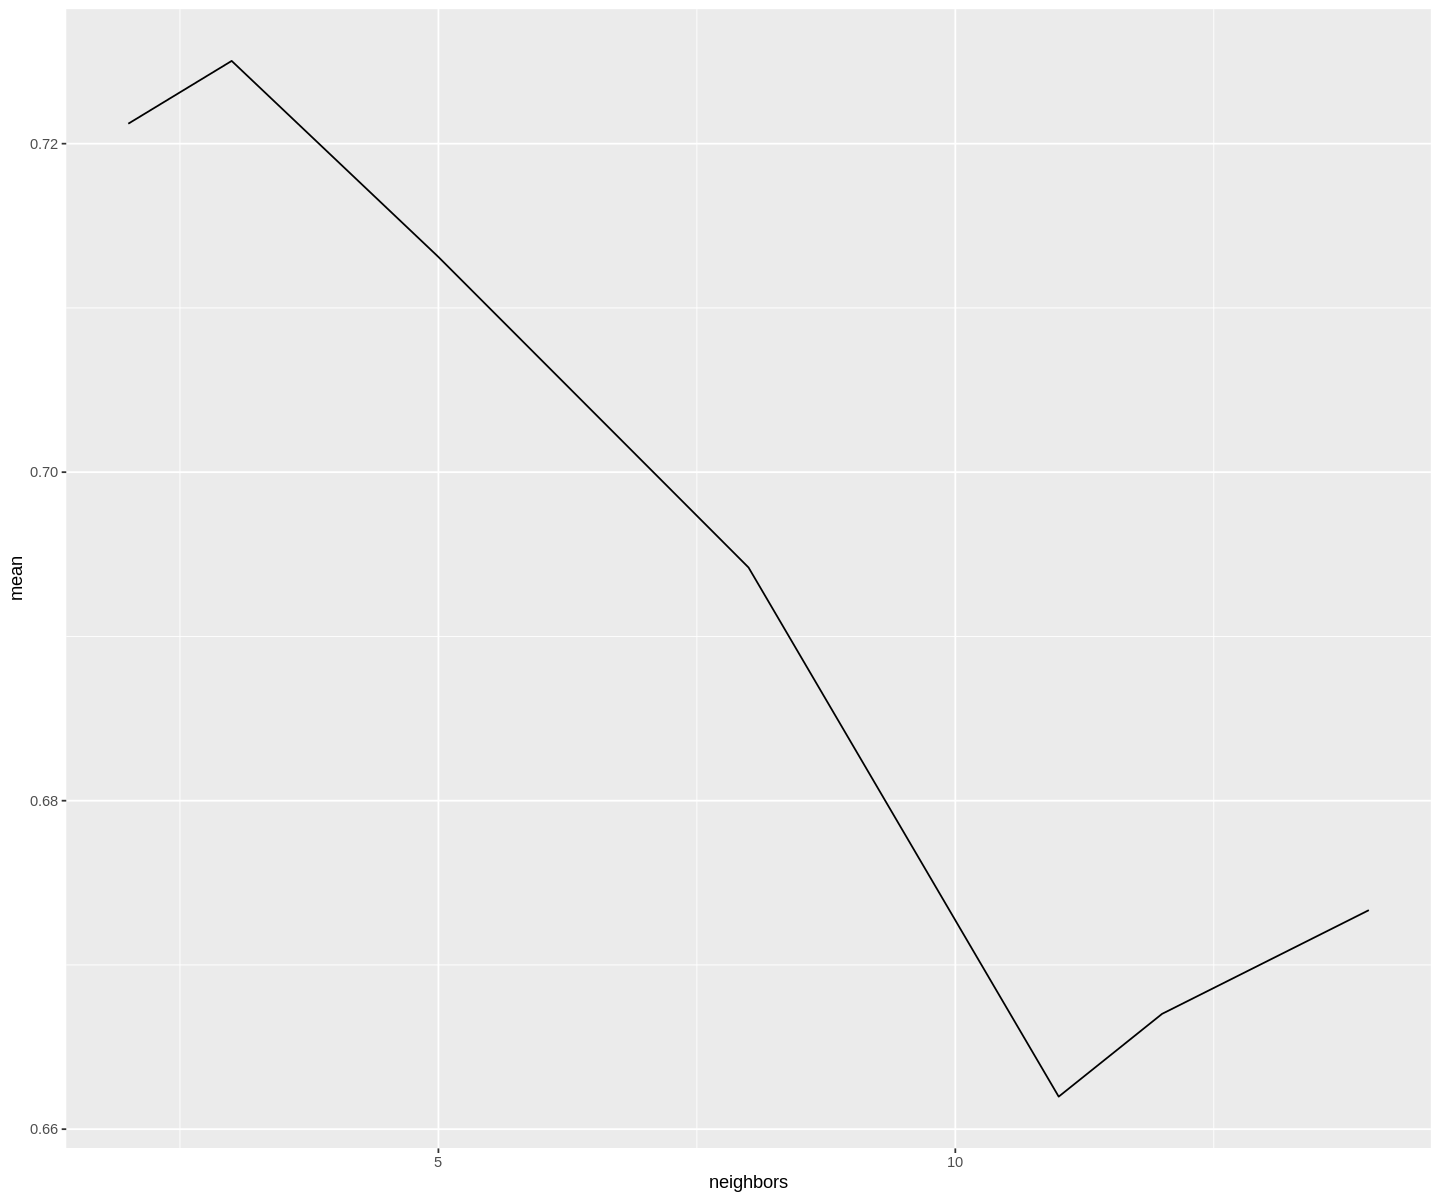

In [126]:
set.seed(255) 

min_vfold <- vfold_cv(obesity_train, v = 5, strata = NObeyesdad)

min_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

obesity_recipe <- recipe(NObeyesdad ~ Weight + FAF + CH2O + TUE, data = obesity_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())  
 

k_data <- workflow() %>%
        add_recipe(obesity_recipe) %>%
        add_model(min_spec) %>%
        tune_grid(resamples = min_vfold, grid = 10) %>%
        collect_metrics() %>%
        filter(.metric == "accuracy") %>%
        arrange(desc(mean))

k_plot <- ggplot(k_data, aes(x = neighbors, y = mean)) +
            geom_line()

k_plot

k_min <- k_data %>%
            slice(1) %>%
            pull(neighbors)

### Using our K to create the model

In [127]:
set.seed(255)

obesity_vfold <- vfold_cv(obesity_train, v = 5, strata = NObeyesdad)

obesity_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = k_min) %>%
                set_engine("kknn") %>%
                set_mode("classification")


obesity_fit <- workflow() %>%
        add_recipe(obesity_recipe) %>%
        add_model(obesity_spec) %>%
        fit(obesity)

### Testing the model

In [128]:
set.seed(255)
predictions <- predict(obesity_fit, obesity_test) %>%
                bind_cols(obesity_test)

head(predictions)

obesity_metrics <- predictions %>%
                metrics(truth = NObeyesdad, estimate = .pred_class)

obesity_conf_mat <- predictions %>%
                conf_mat(truth = NObeyesdad, estimate = .pred_class)

obesity_metrics
obesity_conf_mat

.pred_class,Weight,FAF,CH2O,TUE,NObeyesdad
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Overweight_Level_I,87,2,1,0,Overweight_Level_I
Normal_Weight,53,3,1,0,Normal_Weight
Overweight_Level_II,80,2,1,1,Overweight_Level_II
Obesity_Type_II,102,1,0,0,Overweight_Level_II
Overweight_Level_I,70,0,1,0,Overweight_Level_I
Normal_Weight,60,1,1,0,Normal_Weight


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8933333
kap,multiclass,0.8754179


                     Truth
Prediction            Normal_Weight Overweight_Level_I Overweight_Level_II
  Normal_Weight                  63                  4                   5
  Overweight_Level_I              2                 59                   2
  Overweight_Level_II             2                  7                  54
  Obesity_Type_I                  0                  2                   7
  Insufficient_Weight             4                  0                   3
  Obesity_Type_II                 0                  0                   1
  Obesity_Type_III                0                  0                   0
                     Truth
Prediction            Obesity_Type_I Insufficient_Weight Obesity_Type_II
  Normal_Weight                    0                   4               0
  Overweight_Level_I               1                   0               0
  Overweight_Level_II              8                   0               1
  Obesity_Type_I                  77                  

## Prediction

In [130]:
set.seed(255)
new_obs <- tibble(Weight = runif(1,60,100), FAF = runif(1,0,3), CH2O = runif(1,0,2), TUE = runif(1,0,3), NObeyesdad = "Unknown")

obesity_new <- rbind(obesity, new_obs)

new_pred <- predict(obesity_fit, new_obs) %>%
                    bind_cols(new_obs) %>%
                    rename(Prediction = .pred_class)

new_pred

Prediction,Weight,FAF,CH2O,TUE,NObeyesdad
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Overweight_Level_II,80.9716,1.708775,1.08269,1.419376,Unknown


## Visualization of the analysis

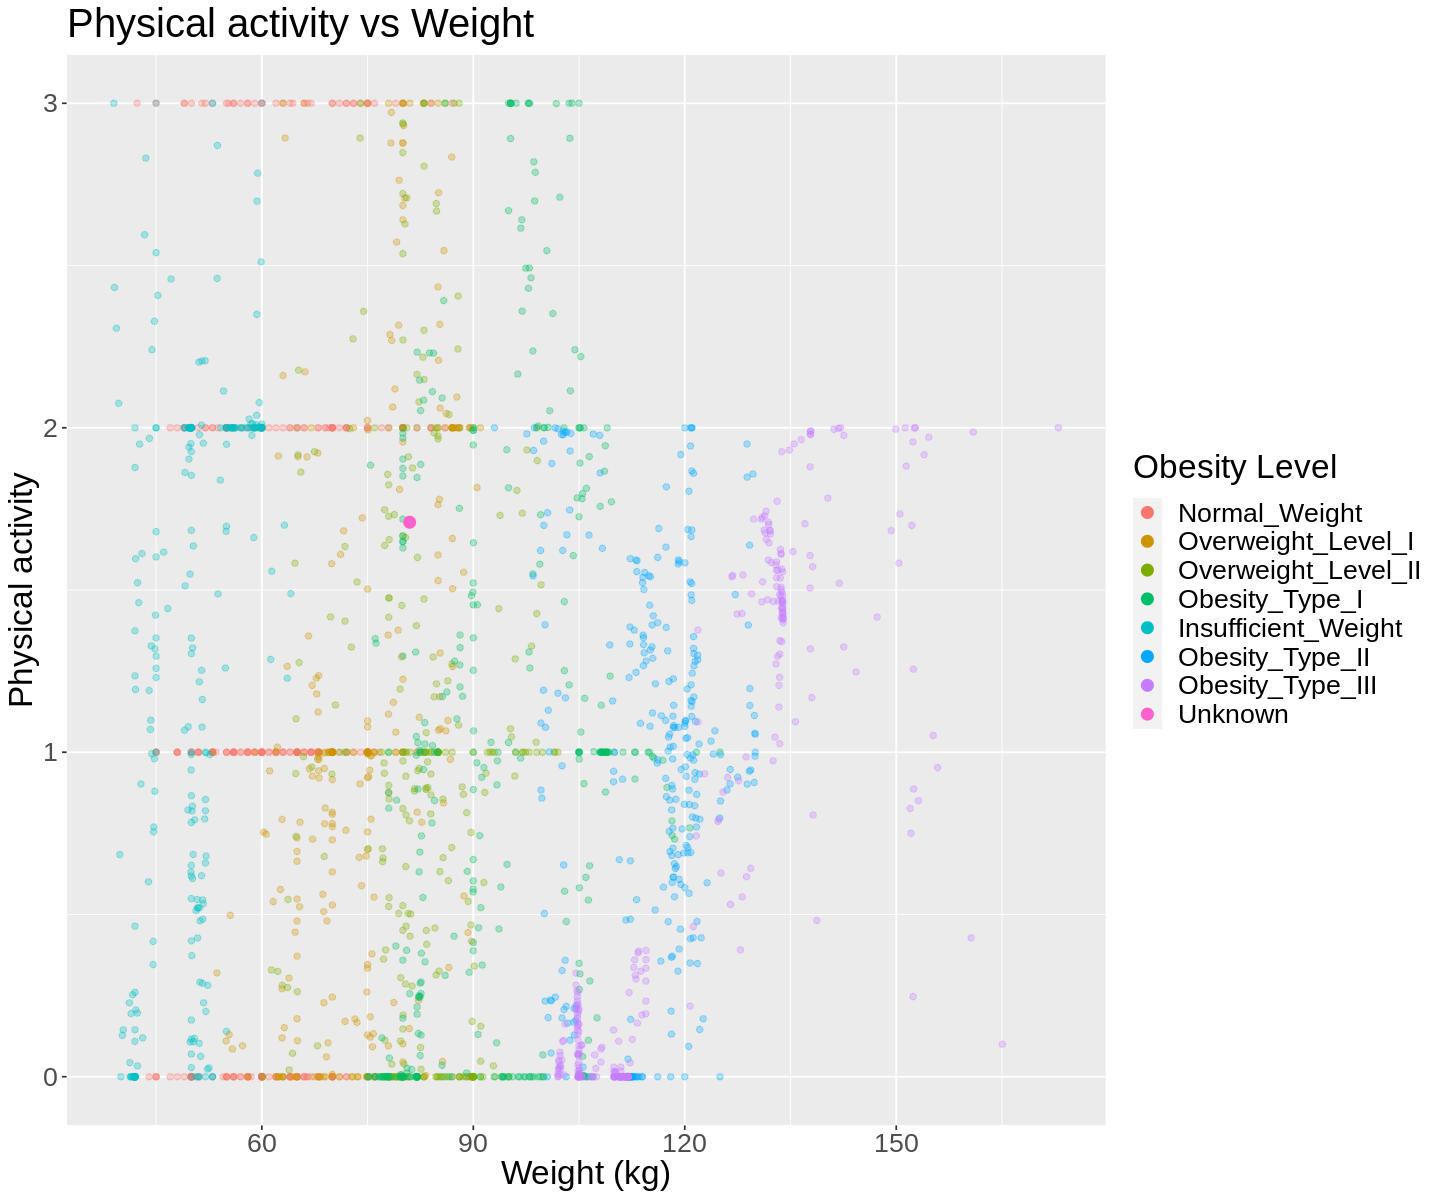

In [131]:
options(repr.plot.width = 12, repr.plot.height = 10)

weightfaf_plot <- ggplot(obesity_new, aes(x = Weight, y = FAF, colour = NObeyesdad)) +
                geom_point(alpha = 0.3) +
                geom_point(data = new_obs, aes(x = Weight, y = FAF, col = NObeyesdad), size = 3) +
                labs(x = "Weight (kg)", y = "Physical activity", color = "Obesity Level", title = "Physical activity vs Weight") +
                theme(text = element_text(size = 20))            
                

weightfaf_plot

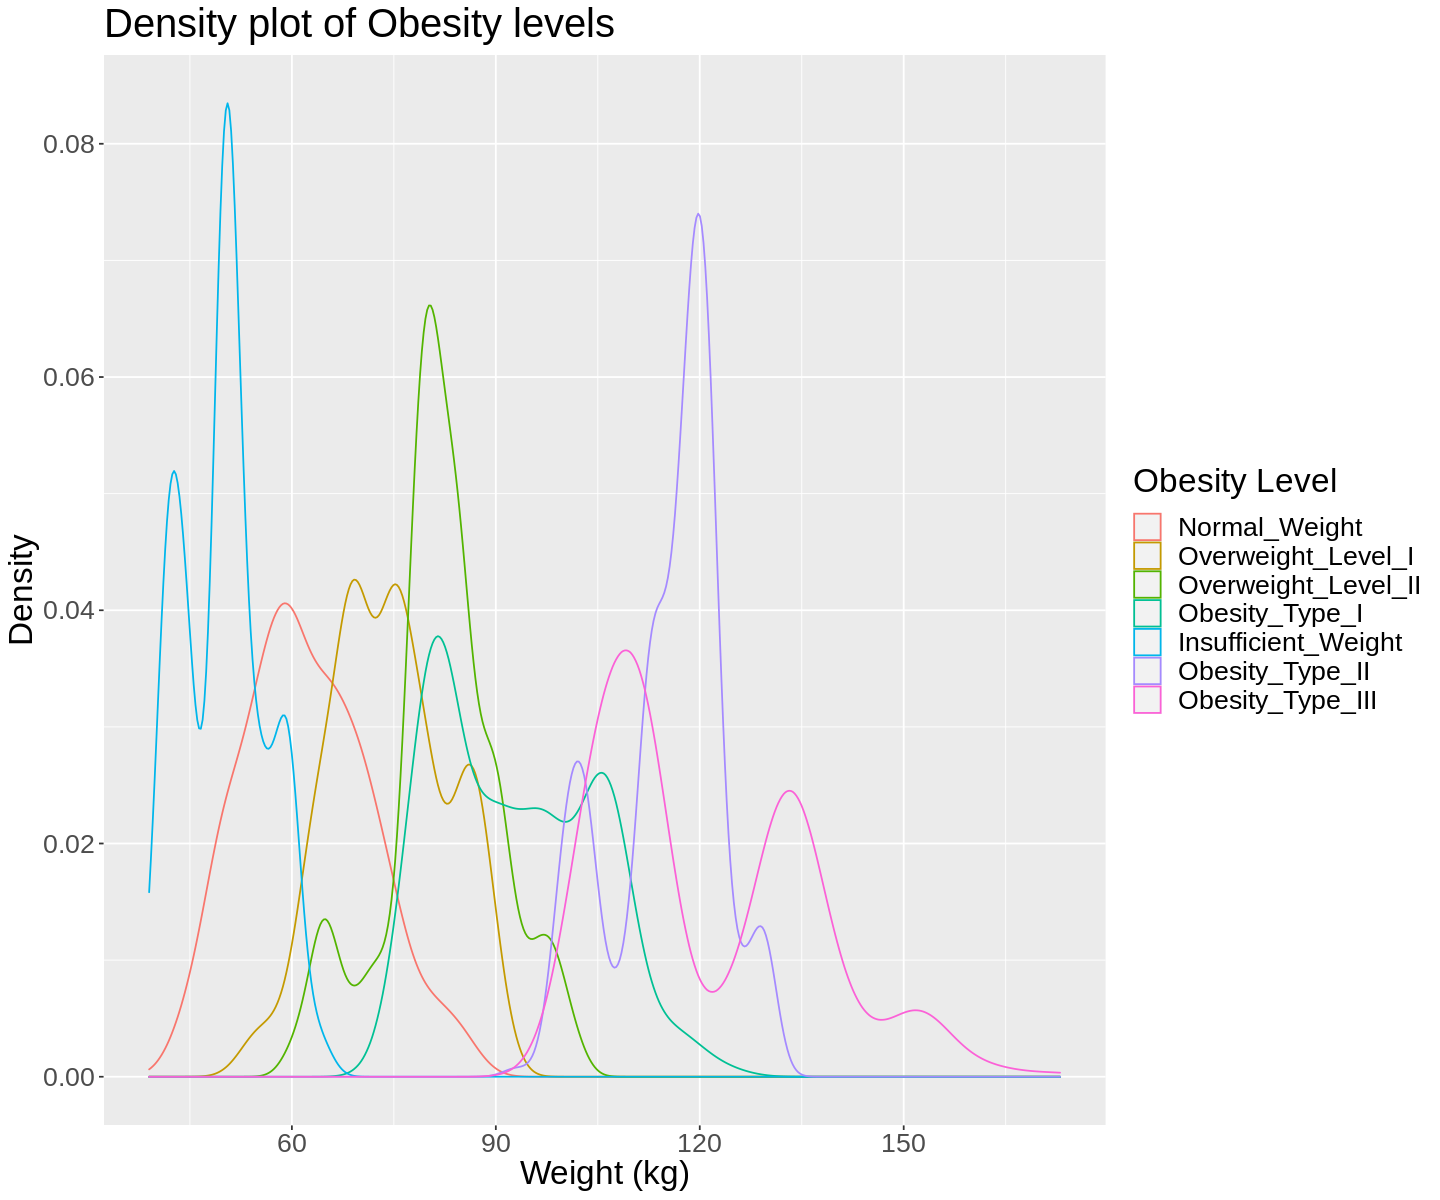

In [132]:
weight_dist <- ggplot(obesity, aes(x = Weight, colour = NObeyesdad)) +
                geom_density() +
                labs(x = "Weight (kg)", y = "Density", color = "Obesity Level", title = "Density plot of Obesity levels") +
                theme(text = element_text(size = 20))  

weight_dist